# Customer Segmentation Analysis for Telecommunications Company

## Introduction
This notebook explores customer segmentation for a telecommunications company using Principal Component Analysis (PCA) and clustering techniques. We analyze customer data to identify meaningful segments based on purchasing and usage behavior. The goal is to create interpretable customer groups that can inform business strategies and marketing efforts.

By understanding different customer segments, the company can:
- Develop targeted marketing campaigns
- Improve customer retention strategies
- Optimize product offerings for specific customer groups
- Predict and prevent customer churn


## Library Imports
In this section, we import all the necessary libraries for our analysis:
- **matplotlib.pyplot and seaborn**: For data visualization
- **numpy and pandas**: For data manipulation and analysis
- **plotly.express**: For interactive visualizations
- **sklearn.metrics**: For clustering evaluation metrics
- **sklearn.cluster**: For KMeans and DBSCAN clustering algorithms
- **sklearn.decomposition**: For Principal Component Analysis (PCA)
- **sklearn.preprocessing**: For data preprocessing (StandardScaler, LabelEncoder)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## Utility Functions
This section defines several utility functions that will be used throughout the analysis.

### Categorical Labels Transformation
This function transforms categorical variables into numerical values using LabelEncoder. This is necessary because clustering algorithms require numerical inputs.


In [2]:
def categorical_labels_transformation(dataframe, columns_list):
    for i in columns_list:    
        temp_encoder = LabelEncoder().fit(dataframe[i])
        dataframe[i] = temp_encoder.fit_transform(dataframe[i])
        print('Feature transformed: '+ str(i))
        print('Classes: '+ str(temp_encoder.classes_))
        print('Transformations:' + str( temp_encoder.fit_transform(temp_encoder.classes_)) + '\n---------------\n')

    return dataframe

### PCA Application Function
This function applies Principal Component Analysis (PCA) to reduce the dimensionality of the data. It:
1. Standardizes the data (essential for PCA)
2. Fits a PCA model with the specified number of components
3. Creates visualizations to help determine the optimal number of components
4. Returns the transformed data and the PCA model for further analysis

PCA is useful for:
- Reducing dimensionality while preserving most of the variance
- Removing multicollinearity between features
- Visualizing high-dimensional data in a lower-dimensional space


In [3]:
# insert to 'pca_list' the columns you would like to perform PCA of the dataframe 'dataf'

def applying_PCA(dataf, pca_list_temp = None, number_of_components = None):

    if pca_list_temp == None: pca_list = dataf.columns.values 
    else: pca_list = pca_list_temp

    if number_of_components == None: number_of_components = len(dataf.columns.values)-1 

    # scale the data:
    X = dataf[pca_list]
    df_scaled = StandardScaler().fit_transform(X)
    #applying the PCA for creating graphs
    pca_max = PCA(n_components = len(X.columns.values) - 1 , random_state = 42).fit(df_scaled)

    #plots ######################
    fig, ax = plt.subplots(figsize = (15, 4), nrows=1, ncols=2)

    ######
    # ax 0
    ax[0].plot(pca_max.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    ax[0].set(
        xlabel = 'Component',
        ylabel = 'Percent of Explained variance for 14 components',
        title = 'Scree Plot',
        ylim = (0,.5)    
          );
    ax[0].grid()

    ######
    # ax 1
    ax[1].plot(np.cumsum(pca_max.explained_variance_ratio_),  'o-', linewidth=2, color='red')
    ax[1].set(
        xlabel = 'Component',
        ylabel = 'Percent of Explained variance for 14 components',
        title = 'Cumulative Variance',
        ylim = (0,1)
          );
    ax[1].grid()


    ##### applying PCA model and inserting the results
    pca_model = PCA(n_components = number_of_components, random_state = 42).fit(df_scaled)

    pca = PCA(n_components = number_of_components, random_state = 42).fit_transform(df_scaled)
    df_pca = pd.DataFrame(pca)

    if pca_list_temp == None:
        data_inputs = df_pca
    else:
        datafr = dataf.drop(pca_list, axis = 1)

        data_inputs = df_pca.reset_index().merge(datafr.reset_index(),
                                                         on = 'index',
                                                         how = 'inner').set_index('index')


    # renaming PCA columns fro 0,1,... to PC_0, PC_1...
    pc_names = []
    old_names = []
    for i in range(0,number_of_components+1):
        old_names.append(i)
        pc_names.append('PC_'+ str(i))

    names_dict = {old_names[i]: pc_names[i] for i in range(len(old_names))}
    data_inputs = data_inputs.rename(names_dict, axis = 1)




    data_inputs.info()
    return data_inputs, pca_model

### K-means Evaluation Function
This function evaluates K-means clustering for different numbers of clusters (k) using multiple evaluation metrics:
1. **Inertia**: Sum of squared distances to the nearest centroid (lower is better, but always decreases with more clusters)
2. **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters (higher is better)
3. **Calinski-Harabasz Index**: Ratio of between-cluster variance to within-cluster variance (higher is better)
4. **Davies-Bouldin Index**: Average similarity between clusters (lower is better)

These metrics help determine the optimal number of clusters for our data.


In [4]:
def check_kmeans(X):
    inertias = []
    sils = []
    chs = []
    dbs = []
    sizes = range(2,12)
    for k in sizes:
        k2 = KMeans(random_state = 42, n_clusters = k)
        k2.fit(X)
        inertias.append(k2.inertia_)
        sils.append(metrics.silhouette_score(X, k2.labels_) )
        chs.append(metrics.calinski_harabasz_score(X, k2.labels_) )
        dbs.append(metrics.davies_bouldin_score(X, k2.labels_) )

    fig, ax = plt.subplots(figsize = (10, 6))

    pd.DataFrame(
        { "inertia": inertias,
         "silhouette": sils,
         "calinski": chs,
         "davis": dbs,
         "k":sizes
        }).set_index("k").plot(ax=ax, subplots=True, layout=(2,2) )

## Data Loading and Exploration
In this section, we load the telecommunications customer data from a CSV file and begin exploring its structure and content. The dataset contains information about customer demographics, service usage, and churn status.


In [5]:
# data import from csv:
df = pd.read_csv('data/telco_churn_data.csv')

# Define the target variable (customer churn)
txt_target_var = 'Churn Value'

# Check the unique values of the target variable
print(df[txt_target_var].unique()) # this is the target variable

# Extract the target column for later use
target_column = df[[txt_target_var]]


[1 0]


### Identifying Categorical Variables
Before we can apply clustering algorithms, we need to identify and transform categorical variables into numerical values. Here we identify all object-type columns and also include 'Customer Satisfaction' which is an ordinal variable.


In [6]:
# Identify all categorical columns (object data type)
text_categories = df.select_dtypes(include= ['object']).columns.values

# Add 'Customer Satisfaction' which is an ordinal variable but stored as numeric
text_categories = np.append(text_categories, 'Customer Satisfaction')

# Print the type and list of categorical variables
print(type(text_categories))
print(text_categories)


<class 'numpy.ndarray'>
['Customer ID' 'Referred a Friend' 'Offer' 'Phone Service'
 'Multiple Lines' 'Internet Service' 'Internet Type' 'Online Security'
 'Online Backup' 'Device Protection Plan' 'Premium Tech Support'
 'Streaming TV' 'Streaming Movies' 'Streaming Music' 'Unlimited Data'
 'Contract' 'Paperless Billing' 'Payment Method' 'Gender' 'Under 30'
 'Senior Citizen' 'Married' 'Dependents' 'City' 'Churn Category'
 'Churn Reason' 'Customer Satisfaction']


### Dataset Information
Let's examine the structure of our dataset, including data types and missing values.


In [7]:
# Display information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Offer                              3166 non-null   object 
 5   Phone Service                      7043 non-null   object 
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Multiple Lines                     7043 non-null   object 
 8   Internet Service                   7043 non-null   object 
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   objec

### Categorical Data Transformation
Now we'll transform all categorical variables into numerical values using our utility function. This is necessary because clustering algorithms require numerical inputs.


In [8]:
# Apply the categorical labels transformation function to convert categorical variables to numeric
df_trf = categorical_labels_transformation(df, columns_list=text_categories)


Feature transformed: Customer ID
Classes: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Transformations:[   0    1    2 ... 7040 7041 7042]
---------------

Feature transformed: Referred a Friend
Classes: ['No' 'Yes']
Transformations:[0 1]
---------------

Feature transformed: Offer
Classes: ['Offer A' 'Offer B' 'Offer C' 'Offer D' 'Offer E' nan]
Transformations:[0 1 2 3 4 5]
---------------

Feature transformed: Phone Service
Classes: ['No' 'Yes']
Transformations:[0 1]
---------------

Feature transformed: Multiple Lines
Classes: ['No' 'Yes']
Transformations:[0 1]
---------------

Feature transformed: Internet Service
Classes: ['No' 'Yes']
Transformations:[0 1]
---------------

Feature transformed: Internet Type
Classes: ['Cable' 'DSL' 'Fiber Optic' nan]
Transformations:[0 1 2 3]
---------------

Feature transformed: Online Security
Classes: ['No' 'Yes']
Transformations:[0 1]
---------------

Feature transformed: Online Backup
Classes: ['No' 'Yes

### Data Cleaning and Preparation
We need to remove unnecessary columns that won't contribute to our clustering analysis, such as identifiers and location data. We also remove the target variable since we want to discover natural patterns in the data without being influenced by the churn status.


In [9]:
# list of variables to drop:
todrop_list = [
    'Customer ID',  # Unique identifier, not useful for clustering
    'City',         # Location data that might bias clustering
    'Zip Code',     # Location data that might bias clustering
    'Longitude',    # Location data that might bias clustering
    'Latitude'      # Location data that might bias clustering
]

# dropping columns not needed for the KMEANS + dropping the target variable:
df_trf = df_trf.drop([txt_target_var], axis = 1).drop(todrop_list, axis = 1)

### Feature Selection for PCA
For PCA, we select a mix of numerical features and transformed categorical features. We focus on features related to customer behavior, demographics, and service usage that might help identify meaningful customer segments.


In [10]:
# Define the list of features for PCA
pca_list_1 = [
    # Customer behavior metrics
    'Number of Referrals',
    'Tenure in Months',
    'Avg Monthly Long Distance Charges',
    'Avg Monthly GB Download',
    'Monthly Charge',
    'Total Regular Charges',
    'Total Refunds',
    'Total Extra Data Charges',
    'Total Long Distance Charges',

    # Demographics
    'Age',
    'Number of Dependents',
    'Population', 
    'CLTV',  # Customer Lifetime Value

    # Service quality and issues
    'Total Customer Svc Requests', 
    'Product/Service Issues Reported',

    # Categorical features (already transformed to numeric)
    'Churn Reason',
    'Churn Category',
    'Customer Satisfaction',
    'Offer'
]


### Applying PCA
Now we'll apply PCA to reduce the dimensionality of our data while preserving most of the variance. We'll use our utility function to apply PCA with 6 components, which should capture a significant portion of the variance in the data.


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PC_0                    7043 non-null   float64
 1   PC_1                    7043 non-null   float64
 2   PC_2                    7043 non-null   float64
 3   PC_3                    7043 non-null   float64
 4   PC_4                    7043 non-null   float64
 5   PC_5                    7043 non-null   float64
 6   Referred a Friend       7043 non-null   int64  
 7   Phone Service           7043 non-null   int64  
 8   Multiple Lines          7043 non-null   int64  
 9   Internet Service        7043 non-null   int64  
 10  Internet Type           7043 non-null   int64  
 11  Online Security         7043 non-null   int64  
 12  Online Backup           7043 non-null   int64  
 13  Device Protection Plan  7043 non-null   int64  
 14  Premium Tech Support    7043 non-null   int64

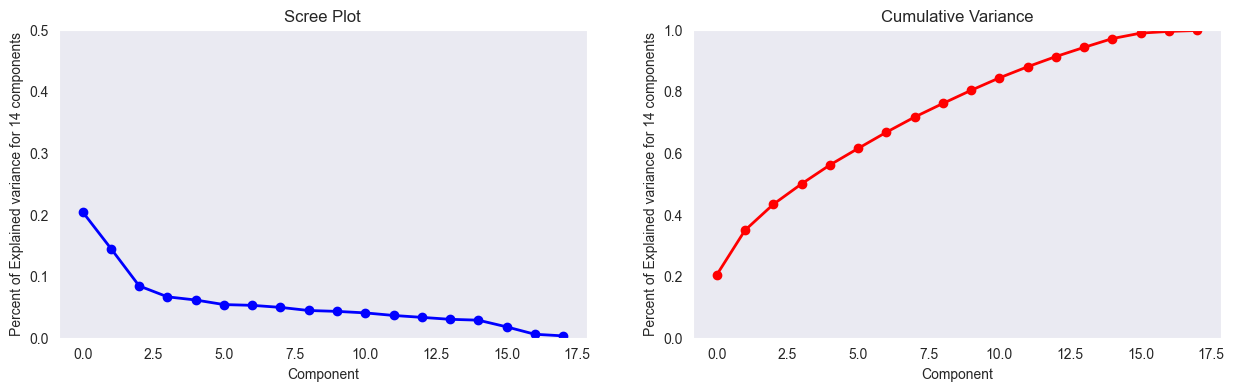

In [11]:
# Apply PCA with 6 components to our selected features
data_tocluster, pca_model = applying_PCA(df_trf, pca_list_temp = pca_list_1, number_of_components = 6)

### Examining PCA Results
Let's examine the first few rows of our transformed data to understand its structure after applying PCA.


In [12]:
# Display the first few rows of the PCA-transformed data
data_tocluster.head()


,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,Referred a Friend,Phone Service,Multiple Lines,Internet Service,...,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Gender,Under 30,Senior Citizen,Married,Dependents
index,,,,,,,,,,,,,,,,,,,,,
0,-3.487344,0.773401,-0.963985,-1.761770,0.457432,0.969479,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
1,-2.334320,2.094315,-1.352114,0.747594,0.486574,1.042876,1,1,1,1,...,0,0,0,1,1,0,0,1,1,1
2,-1.377555,1.409402,1.235237,-1.329617,0.267093,5.273319,0,1,1,1,...,1,1,0,1,0,1,0,1,0,1
3,-0.824203,2.018798,-1.103615,-1.435562,1.197328,1.102898,1,1,0,1,...,0,0,0,1,0,0,0,1,1,1
4,-0.822722,0.881507,-0.498328,-1.719395,0.663032,0.019944,1,1,1,1,...,0,0,0,1,0,0,0,1,1,1


### Determining Optimal Number of Clusters
Before applying clustering algorithms, we need to determine the optimal number of clusters. We'll use our utility function to evaluate K-means with different numbers of clusters using multiple evaluation metrics.


/var/folders/c8/d6_c0zkx1dx9ycv8s9yl87gr0000gn/T/ipykernel_36752/1076258659.py:23: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  }).set_index("k").plot(ax=ax, subplots=True, layout=(2,2) )


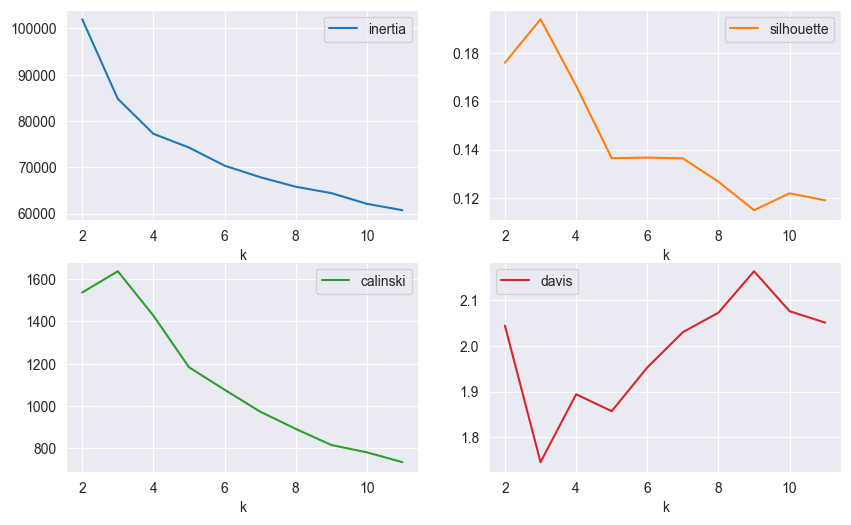

In [13]:
# Evaluate K-means with different numbers of clusters (k=2 to k=11)
check_kmeans(data_tocluster)

## Clustering Model Implementation
Based on the evaluation metrics, we'll implement multiple clustering models:
1. K-means with 2 clusters (binary segmentation)
2. K-means with 3 clusters (more granular segmentation)
3. DBSCAN (density-based clustering that can identify outliers)

Using multiple clustering approaches allows us to compare different segmentation strategies and choose the most meaningful one for business purposes.


In [14]:
# Models initialisation and input data declaration:
kmeans_2 = KMeans(random_state = 42, n_clusters = 2)  # K-means with 2 clusters
kmeans_3 = KMeans(random_state = 42, n_clusters = 3)  # K-means with 3 clusters
dbscan = DBSCAN(eps = 2, min_samples = 5)  # DBSCAN with epsilon=2 and min_samples=5

### Fitting Clustering Models
Now we'll fit our clustering models to the PCA-transformed data. We'll focus on using only the principal components (PC_0 through PC_5) rather than all features, as these components capture the most important patterns in the data.


In [15]:
# Define the list of principal components to use for clustering
PCA_names_list = ['PC_0','PC_1','PC_2','PC_3','PC_4', 'PC_5']

# Fit K-means with 2 clusters and extract labels
kmeans_2_labels = pd.DataFrame(kmeans_2.fit(data_tocluster[PCA_names_list]).labels_).rename({0:'KM2_Label'}, axis = 1)

# Fit K-means with 3 clusters and extract labels
kmeans_3_labels = pd.DataFrame(kmeans_3.fit(data_tocluster[PCA_names_list]).labels_).rename({0:'KM3_Label'}, axis = 1)

# Fit DBSCAN and extract labels
dbscan_labels = pd.DataFrame(dbscan.fit(data_tocluster[PCA_names_list]).labels_).rename({0:'DBSCAN_Label'}, axis = 1)

### Combining Cluster Labels
Now we'll combine the labels from all three clustering models into a single dataframe. This will allow us to compare the results of different clustering approaches.


In [16]:
# Combine K-means with 2 clusters and K-means with 3 clusters labels
tempdf = kmeans_2_labels.reset_index().merge(
                      right = kmeans_3_labels.reset_index(),
                      how = 'inner',
                      right_on = 'index', left_on = 'index'
                                            )
# Add DBSCAN labels to create a complete labels dataframe
all_labels = tempdf.merge(
                      right = dbscan_labels.reset_index(),
                      how = 'inner',
                      right_on = 'index', left_on = 'index'
                         )

### Preparing Data for Analysis and Visualization
To analyze our clusters effectively, we need to merge the cluster labels with both:
1. The original dataset (to understand cluster characteristics in terms of original features)
2. The PCA-transformed data (for visualization in the reduced dimensional space)
3. The target variable (to see how clusters relate to churn)


In [17]:
# Merge cluster labels with the original dataset
df_all = all_labels.merge(
                      right = df.reset_index(),
                      how = 'inner',
                      right_on = 'index', left_on = 'index'
                         )

# Merge cluster labels with the PCA-transformed data
data_tocluster_all = all_labels.merge(
                      right = data_tocluster.reset_index(),
                      how = 'inner',
                      right_on = 'index', left_on = 'index'
                         )

# Add the target variable (Churn Value) to the PCA-transformed data with cluster labels
data_tocluster_all = data_tocluster_all.merge(
                      right = df[[txt_target_var]].reset_index(),
                      how = 'inner',
                      right_on = 'index', left_on = 'index'
                         )

# Check the structure of our final dataset for analysis
data_tocluster_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   7043 non-null   int64  
 1   KM2_Label               7043 non-null   int32  
 2   KM3_Label               7043 non-null   int32  
 3   DBSCAN_Label            7043 non-null   int64  
 4   PC_0                    7043 non-null   float64
 5   PC_1                    7043 non-null   float64
 6   PC_2                    7043 non-null   float64
 7   PC_3                    7043 non-null   float64
 8   PC_4                    7043 non-null   float64
 9   PC_5                    7043 non-null   float64
 10  Referred a Friend       7043 non-null   int64  
 11  Phone Service           7043 non-null   int64  
 12  Multiple Lines          7043 non-null   int64  
 13  Internet Service        7043 non-null   int64  
 14  Internet Type           7043 non-null   

## Cluster Visualization and Analysis
Now that we have our clusters, we'll visualize and analyze them to understand their characteristics and relationships with other variables.

### Visualizing Clusters in PCA Space
First, let's visualize how our clusters are distributed in the PCA space. We'll create scatter plots of the first two principal components (PC_0 and PC_1), which capture the most variance in the data.


<Axes: title={'center': 'Scatterplot of PC_0 vs PC_1 clustered by 3 groups (KMeans)'}, xlabel='PC_0', ylabel='PC_1'>

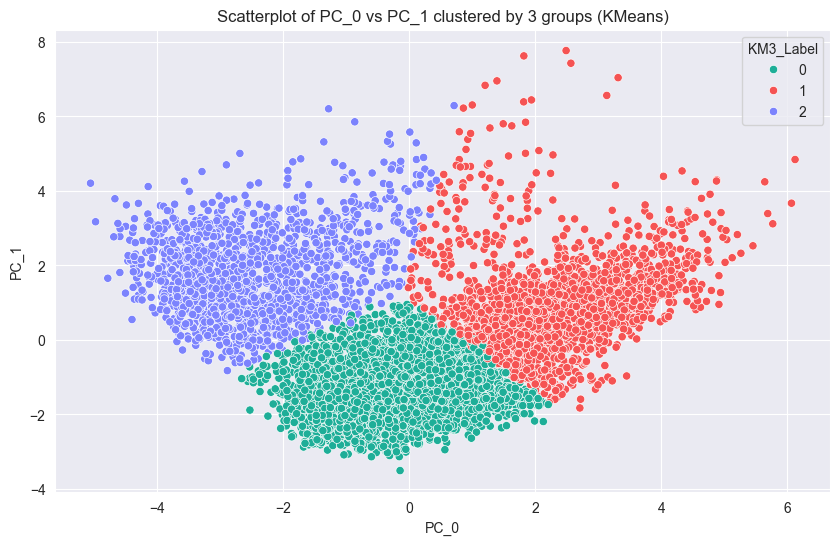

In [18]:
plt.figure(figsize = (10,6))

plt.title('Scatterplot of PC_0 vs PC_1 clustered by 3 groups (KMeans)')

# Create a scatter plot of PC_0 vs PC_1 colored by K-means clusters
sns.scatterplot(data = data_tocluster_all,
                x = "PC_0",
                y = "PC_1",
                hue = 'KM3_Label',
                palette = ['#1EAE98', '#F55353', '#7C83FD']
               )


### Relationship Between Clusters and Churn
Now let's examine how our clusters relate to customer churn. This will help us understand if certain customer segments are more likely to churn than others.


<Axes: title={'center': 'Scatterplot of PC_0 vs PC_1 colored by Churn Value'}, xlabel='PC_0', ylabel='PC_1'>

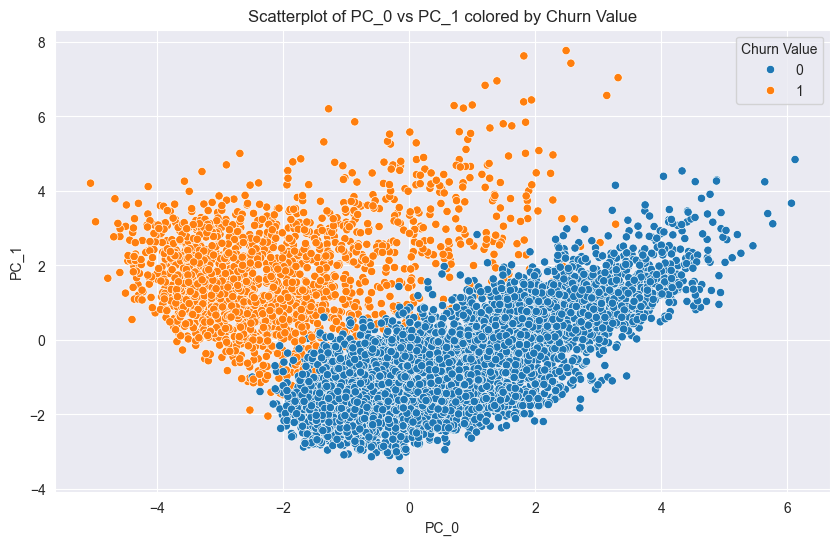

In [19]:
plt.figure(figsize = (10,6))

plt.title('Scatterplot of PC_0 vs PC_1 colored by Churn Value')

# Create a scatter plot of PC_0 vs PC_1 colored by Churn Value
sns.scatterplot(data = data_tocluster_all,
                x = "PC_0",
                y = "PC_1",
                hue = 'Churn Value'
               )

### Geographical Distribution of Clusters
Let's examine the geographical distribution of one of our clusters (Cluster 2) and see how it relates to churn. This can help identify if there are regional patterns in customer behavior.


In [26]:
# Create an interactive map showing the geographical distribution of Cluster 2 customers
fig = px.scatter_mapbox(df_all.query('KM3_Label == 2'),
                        lat="Latitude",
                        lon="Longitude",
                        color = "Churn Value",
                        zoom=3, 
                        height=300)

# Set the map style to OpenStreetMap
fig.update_layout(mapbox_style="open-street-map")

# Adjust the margins of the plot
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Display the interactive map
fig.show()


/var/folders/c8/d6_c0zkx1dx9ycv8s9yl87gr0000gn/T/ipykernel_36752/1190463215.py:2: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Cluster Distribution by Churn Value
Now let's analyze how customers are distributed across clusters and how this relates to churn. This will help us identify which clusters have higher churn rates.


Text(0, 0.5, 'Count of customers')

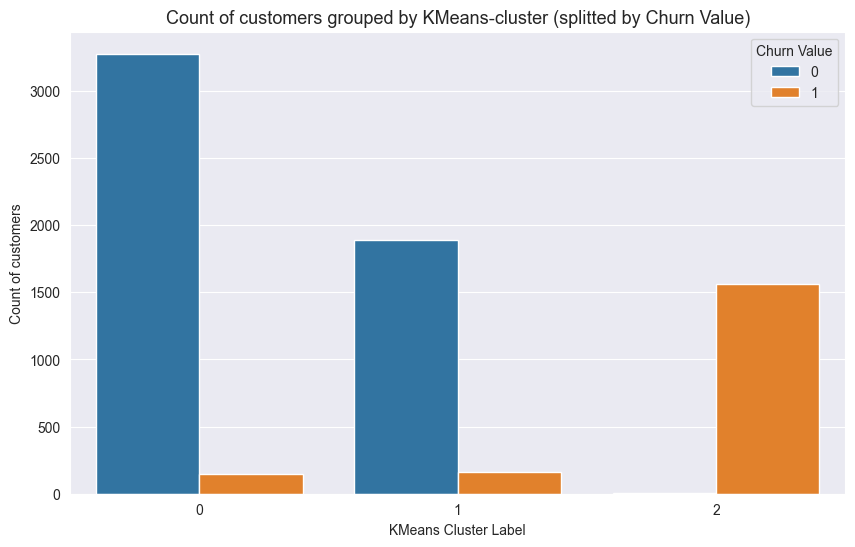

In [21]:
# Create a bar plot showing the count of customers in each cluster, split by churn value
plt.figure(figsize = (10,6))

sns.barplot(data = df_all.groupby(['KM3_Label','Churn Value']).count().reset_index()[['index','KM3_Label','Churn Value']],
            x = 'KM3_Label',
            y = 'index',
            hue = 'Churn Value'
           )

# Add title and labels to the plot
plt.title('Count of customers grouped by KMeans-cluster (splitted by Churn Value)', fontsize = 13)
plt.xlabel('KMeans Cluster Label', fontsize = 10)
plt.ylabel('Count of customers', fontsize = 10)

### Examining Cluster Data
Let's look at a sample of our data with cluster labels to understand what information we have for analysis.


In [22]:
# Display a sample row from our dataset with cluster labels
df_all.head(1)

,index,KM2_Label,KM3_Label,DBSCAN_Label,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,...,Latitude,Longitude,Population,Churn Value,CLTV,Churn Category,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
0,0,0,2,0,6207,0,0,1,5,0,...,34.02381,-118.156582,68701,1,5433,1,5,5,0,5


### Cluster Characteristics
Now let's analyze the characteristics of each cluster by examining the mean values of key features across clusters. This will help us understand what makes each customer segment unique.


In [23]:
# Create a heatmap showing the mean values of principal components for each cluster
data_tocluster_all.groupby('KM3_Label').mean().T.iloc[3:9,:][[1,2]].style.background_gradient(cmap = 'RdBu', axis=1)


KM3_Label,1,2
PC_0,2.318399,-2.477073
PC_1,0.885397,1.733788
PC_2,-0.092529,-0.125016
PC_3,-0.071853,-0.004043
PC_4,-0.017795,0.171813
PC_5,-0.027121,-0.003286


### Visualizing Cluster Characteristics
Let's visualize the mean values of principal components for each cluster to better understand the differences between customer segments.


<Axes: title={'center': 'Mean Values of Each Cluster'}, xlabel='KMeans Inputs', ylabel='Mean of Feature'>

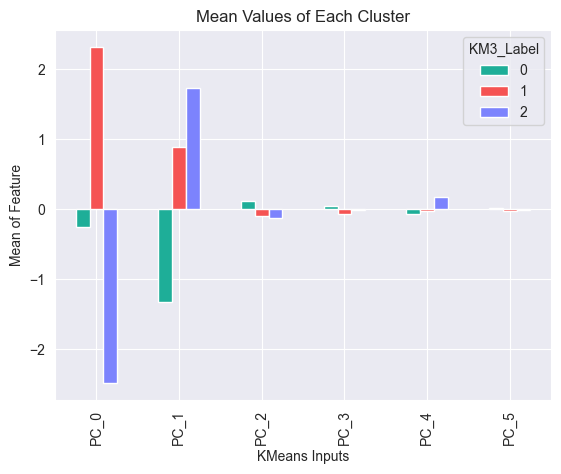

In [24]:
# Create a bar plot showing the mean values of principal components for each cluster
data_tocluster_all.groupby('KM3_Label').mean().T.iloc[3:9,:][[0,1,2]].plot(kind = 'bar',
                                                                         color = ['#1EAE98', '#F55353', '#7C83FD'],
                                                                         title = 'Mean Values of Each Cluster',
                                                                         xlabel = 'KMeans Inputs',
                                                                         ylabel = 'Mean of Feature'
                                                                        )

### Feature Contribution to Principal Components
Finally, let's examine which original features contribute most to our principal components. This will help us interpret what each principal component represents and understand the underlying patterns in our data.


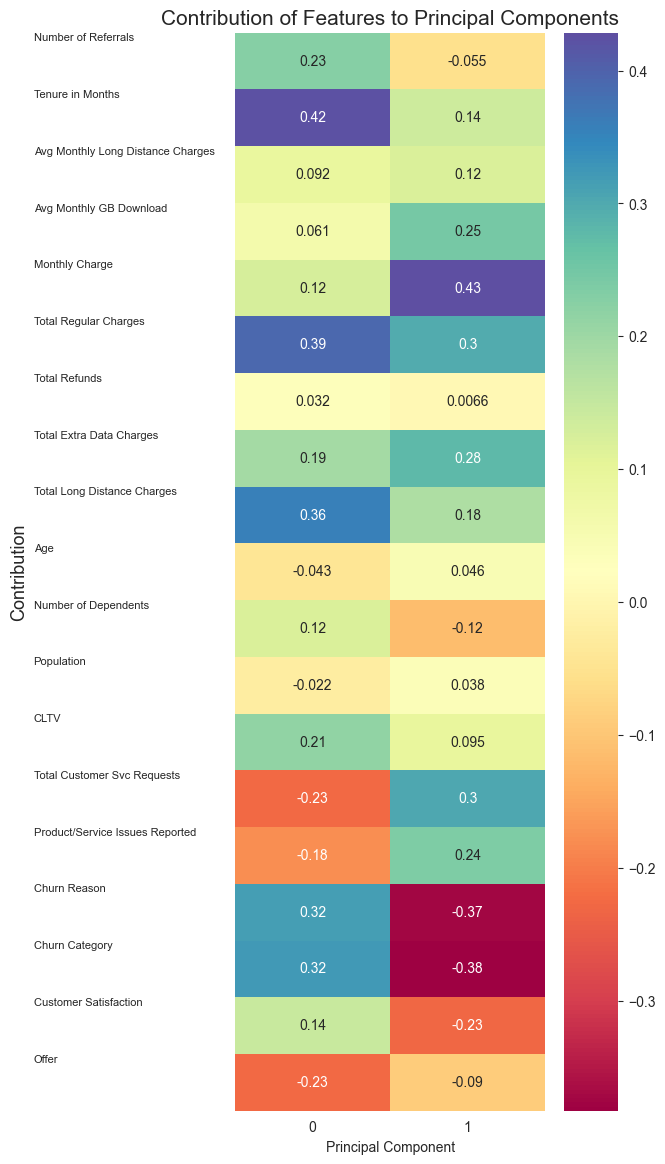

In [25]:
fig, ax = plt.subplots(figsize = (5,14))

# Create a heatmap showing the contribution of each feature to the first two principal components
ax = sns.heatmap(
    data = pd.DataFrame(pca_model.components_.T).iloc[:,:2],
    cmap="Spectral",
    annot = True
)

# Set the y-tick labels to show the original feature names
plt.yticks(range(len(pca_list_1)), pca_list_1, 
           fontsize = 8,
           rotation = 360, 
           ha = 'left', 
           va='top'
          );

# Adjust the tick parameters for better readability
ax.tick_params(axis = 'y',length =145, pad = 0.10)

# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Contribution', fontsize = 13)
plt.title('Contribution of Features to Principal Components', fontsize = 15);


## Conclusion

In this notebook, we performed customer segmentation for a telecommunications company using Principal Component Analysis (PCA) and clustering techniques. Our analysis revealed several distinct customer segments with different characteristics and churn patterns.

### Key Findings:
1. We identified three main customer segments using K-means clustering
2. The clusters show different patterns of churn, with some segments having higher churn rates than others
3. The geographical distribution of customers within clusters reveals regional patterns
4. Principal components capture different aspects of customer behavior, with features like tenure, charges, and service issues contributing significantly

### Business Implications:
1. **Targeted Marketing**: Different strategies can be developed for each customer segment
2. **Churn Prevention**: High-risk segments can be targeted with retention programs
3. **Service Improvement**: Understanding which features contribute to customer dissatisfaction can guide service enhancements
4. **Regional Strategies**: Geographic patterns can inform region-specific approaches

### Next Steps:
1. Develop specific marketing and retention strategies for each customer segment
2. Conduct deeper analysis of high-churn segments to identify specific pain points
3. Implement A/B testing of different approaches for each segment
4. Monitor segment evolution over time to track the effectiveness of interventions

This segmentation provides a foundation for more personalized and effective customer relationship management, potentially leading to improved customer satisfaction and reduced churn.
